# Analyse Cifar100 runs with various learning rates and batch sizes
## Time to get to accuracy 0.6 on DL server

In [1]:
%matplotlib inline
import re
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
import pandas as pd
import subprocess
import os

In [2]:
logdir="logs/flextime/0_6x100/01_SGD/experiment01"

In [11]:
!ls logs/flextime/0_6x100/01_SGD/experiment01/cifar*.log

logs/flextime/0_6x100/01_SGD/experiment01/cifar_log_b1024_l0.001.log
logs/flextime/0_6x100/01_SGD/experiment01/cifar_log_b1024_l0.005.log
logs/flextime/0_6x100/01_SGD/experiment01/cifar_log_b1024_l0.010.log
logs/flextime/0_6x100/01_SGD/experiment01/cifar_log_b1024_l0.025.log
logs/flextime/0_6x100/01_SGD/experiment01/cifar_log_b1024_l0.050.log
logs/flextime/0_6x100/01_SGD/experiment01/cifar_log_b1024_l0.100.log
logs/flextime/0_6x100/01_SGD/experiment01/cifar_log_b1024_l0.150.log
logs/flextime/0_6x100/01_SGD/experiment01/cifar_log_b1024_l0.200.log
logs/flextime/0_6x100/01_SGD/experiment01/cifar_log_b1024_l0.250.log
logs/flextime/0_6x100/01_SGD/experiment01/cifar_log_b1024_l0.300.log
logs/flextime/0_6x100/01_SGD/experiment01/cifar_log_b1152_l0.001.log
logs/flextime/0_6x100/01_SGD/experiment01/cifar_log_b1152_l0.005.log
logs/flextime/0_6x100/01_SGD/experiment01/cifar_log_b1152_l0.010.log
logs/flextime/0_6x100/01_SGD/experiment01/cifar_log_b1152_l0.025.log
logs/flextime/0_6x100/01_SGD/exper

In [5]:
filename_pattern=re.compile(r"cifar_.*\.log")

In [12]:
files=[]
comm = "ls -1 "+logdir
proc = subprocess.Popen(comm.split(" "),
                     stdout=subprocess.PIPE,stderr=subprocess.STDOUT)
for line in iter(proc.stdout.readline,b''):
    m = filename_pattern.match(line)
    if m:
        files.append(os.path.abspath(os.path.join(logdir,line)))
files

['/Users/peterbryzgalov/work/ML/mlbenchmarks/Chainer/logs/flextime/0_6x100/01_SGD/experiment01/cifar_log_b1024_l0.001.log\n',
 '/Users/peterbryzgalov/work/ML/mlbenchmarks/Chainer/logs/flextime/0_6x100/01_SGD/experiment01/cifar_log_b1024_l0.005.log\n',
 '/Users/peterbryzgalov/work/ML/mlbenchmarks/Chainer/logs/flextime/0_6x100/01_SGD/experiment01/cifar_log_b1024_l0.010.log\n',
 '/Users/peterbryzgalov/work/ML/mlbenchmarks/Chainer/logs/flextime/0_6x100/01_SGD/experiment01/cifar_log_b1024_l0.025.log\n',
 '/Users/peterbryzgalov/work/ML/mlbenchmarks/Chainer/logs/flextime/0_6x100/01_SGD/experiment01/cifar_log_b1024_l0.050.log\n',
 '/Users/peterbryzgalov/work/ML/mlbenchmarks/Chainer/logs/flextime/0_6x100/01_SGD/experiment01/cifar_log_b1024_l0.100.log\n',
 '/Users/peterbryzgalov/work/ML/mlbenchmarks/Chainer/logs/flextime/0_6x100/01_SGD/experiment01/cifar_log_b1024_l0.150.log\n',
 '/Users/peterbryzgalov/work/ML/mlbenchmarks/Chainer/logs/flextime/0_6x100/01_SGD/experiment01/cifar_log_b1024_l0.200.

In [13]:
batch_learn_pattern = re.compile(r"^b\s*(\d+)\s+l\s*([0-9\.]+)")
output_pattern = re.compile(r"^(\d+)\s+([0-9\.]+)\s+([0-9\.]+)\s+([0-9\.]+)\s+([0-9\.]+)\s+([0-9\.]+)")

In [14]:
remove_str="[J"
def readfile(filename,debug=False):
    filename = filename.strip(" \n")
    with open(filename,"r") as f:
        lines = f.readlines()
        batch = 0
        epoch = 0    
        run = 0
        loss = 0
        acc = 0
        time = 0
        df = pd.DataFrame(data=None,columns=["batch","learn","loss","acc","time","epochs"])
        for line in lines:
            s = line.strip('\n')
            s = s.replace(remove_str,"")
            #if debug: print line[:75]
            m = batch_learn_pattern.match(s)        
            if m:
                batch = int(m.group(1))
                learn = float(m.group(2))            
                epoch = 0
                run += 1
                if debug: print "New run with:",batch,learn
            else:
                m = output_pattern.match(s)
                if m:
                    epoch = int(m.group(1))
                    if epoch == 100:
                        loss = float(m.group(3))
                        acc = float(m.group(5))
                        time = float(m.group(6))
                        df.loc[run] = [batch,learn,loss,acc,time,epoch]
                        if debug: print "Accuracy not reached",epoch
                    else:
                        loss = float(m.group(3))
                        acc = float(m.group(5))
                        time = float(m.group(6))                    
                else:
                    if epoch > 0 and epoch < 100:
                        if debug: print "Reached accuracy threshold at",epoch
                        if debug: print batch,learn,loss,acc,time
                        df.loc[run] = [batch,learn,loss,acc,time,epoch]
    return df

In [15]:
df = pd.DataFrame(data=None,columns=["batch","learn","loss","acc","time","epochs"])
for file in files:
#print files[2]
    df1 = readfile(file)
    #print df1.head()
    if len(df1) > 0:
        df = pd.concat([df,df1],ignore_index=True)
df.head()

,batch,learn,loss,acc,time,epochs
0,1024.0,0.001,4.76218,0.010124,2478.29,100.0
1,1024.0,0.005,8.19642,0.013355,2440.64,100.0
2,1024.0,0.010,3.44166,0.179837,2454.16,100.0
3,1024.0,0.025,2.40936,0.438698,2448.42,100.0
4,1024.0,0.050,2.06356,0.557862,2446.53,100.0


In [16]:
df_reach = df[df["epochs"]<100]
df_reach.head()

,batch,learn,loss,acc,time,epochs
5,1024.0,0.10,1.83834,0.602758,1866.30,77.0
6,1024.0,0.15,1.75219,0.601971,1569.36,65.0
7,1024.0,0.20,1.78146,0.606732,1820.36,75.0
8,1024.0,0.25,1.71359,0.605650,1728.93,71.0
9,1024.0,0.30,1.71007,0.601377,1592.15,66.0


In [17]:
loss_df = df_reach[['batch','learn','loss']]
acc_df = df[['batch','learn','acc']]
time_df = df_reach[['batch','learn','time']]
epoch_df = df_reach[['batch','learn','epochs']]

In [61]:
def plotHeatMap(df,title=None,cmap=None):
    plt.rcParams['figure.figsize'] = 10,8 
    plt.pcolormesh(df,cmap=cmap)
    plt.yticks(np.arange(0.5, len(df.index), 1), df.index)
    plt.xticks(np.arange(0.5, len(df.columns), 1), df.columns)
    ax = plt.gca()
    ax.tick_params(direction='in', length=0)
    for y in range(df.shape[0]):
        for x in range(df.shape[1]):
            if df.iloc[y,x] > 0:
                plt.text(x+0.5,y+0.5,'{:.3f}'.format(df.iloc[y,x]),
                         color="black",fontsize=9,
                         horizontalalignment='center',
                         verticalalignment='center',                    
                         bbox={'facecolor':'white','edgecolor':'none', 'alpha':0.2, 'pad':0})
    plt.title(title,fontsize=18)
    plt.xlabel("learning rate",fontsize=12)
    plt.ylabel("minibatch size",fontsize=12)
    plt.colorbar()
    plt.show()

In [62]:
loss_df.head()

,batch,learn,loss
5,1024.0,0.10,1.83834
6,1024.0,0.15,1.75219
7,1024.0,0.20,1.78146
8,1024.0,0.25,1.71359
9,1024.0,0.30,1.71007


In [63]:
loss_T = loss_df.pivot_table(index="batch",columns="learn",values="loss")
acc_T = acc_df.pivot_table(index="batch",columns="learn",values="acc")
time_T = time_df.pivot_table(index="batch",columns="learn",values="time")
epoch_T = epoch_df.pivot_table(index="batch",columns="learn",values="epochs")

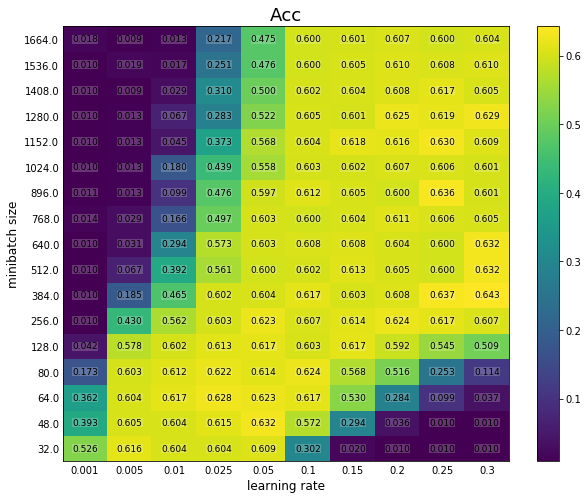

In [64]:
plotHeatMap(acc_T,"Acc")

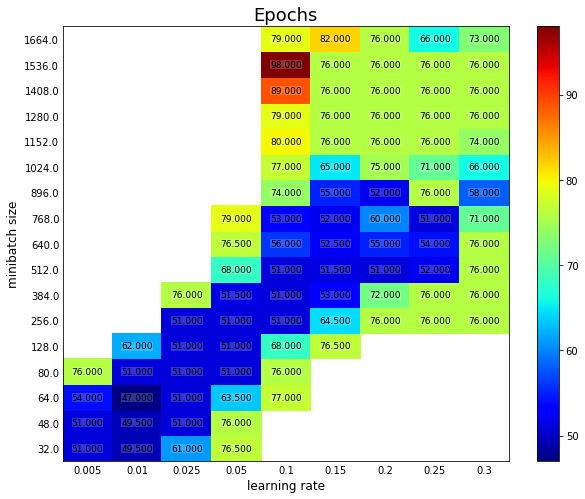

In [65]:
plotHeatMap(epoch_T,"Epochs","jet")

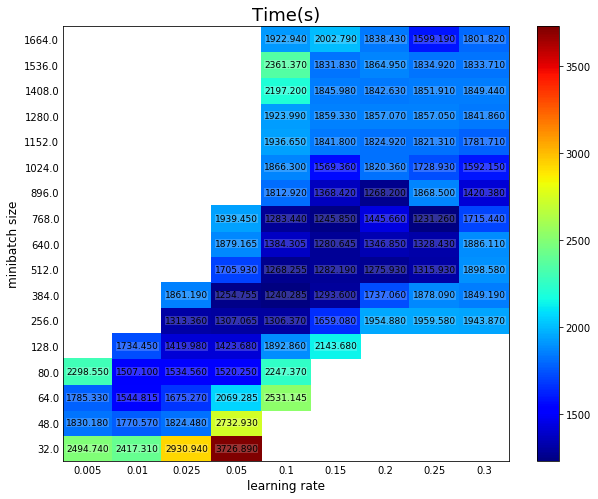

In [66]:
plotHeatMap(time_T,"Time(s)","jet")

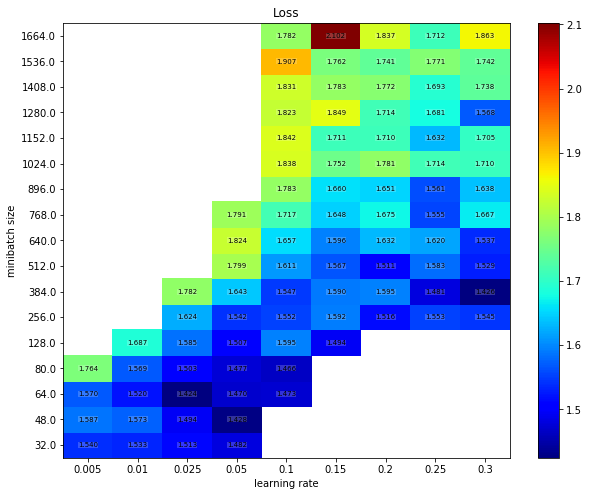

In [45]:
plotHeatMap(loss_T,"Loss","jet")